Copyright 2019 Intel Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction

In Lesson 2 of *Anomaly Detection*, we learned that extreme value analysis can be used to estimate the chance of a rare event happening. We also discussed angle-based and depth-based anomaly detection. While the three approaches are different, they share one feature: they assume that the anomalies lie at the border (or edge or tail) of the data.

Here will apply extreme value analysis to better understand rare events in atmospheric ozone levels (univariate data). We will also use angle-based and depth-based anomaly detection to find anomalies in multivariate data.

# Learning Outcomes

You should walk away from this Python tutorial with:
1. An understanding of extreme value analysis
2. Some practical experience with angle-based anomaly detection 
3. Some practical experience with depth-based anomaly detection 

# Imports

In [1]:
# %matplotlib inline

import sys
import datetime
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

# Python & Library Versions

In [2]:
packages = [matplotlib, np, pd, scipy]

msg = f"""
Python Version: {sys.version}

library        version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]

library        version
-------        -------
matplotlib       3.1.0
numpy           1.16.4
pandas          0.24.2
scipy            1.2.1


---

# Section 1: Extreme Value Analysis

In this section, we use extreme value analysis to detect anomalies in real-world data: ozone levels in the New York metropolitan area. Near ground level, ozone is a respiratory hazard as it can cause damage to mucous and respiratory tissues. The air quality index (AQI) for ozone is a scale from 0 to 500 that describes the level of ozone pollution: the higher the number, the greater the hazard. More details about the scale can be found here:

https://www.airnow.gov/aqi/aqi-basics


The ozone AQI levels for the New York metropolitan area are taken from the US Environmental Protection Agency website:

https://www.epa.gov/outdoor-air-quality-data/air-quality-index-daily-values-report

(Geographic Area is "New York-Newark-Jersey City")

All full years available were selected (1980-2017) and the data for all years were combined into a single CSV file.

Load the data as a pandas dataframe and take a look at it.

In [3]:
ozone_aqi = pd.read_csv('aqidailyozone.csv', 
                        index_col=0, 
                        parse_dates=True) 
ozone_aqi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13880 entries, 1980-01-01 to 2017-12-31
Data columns (total 1 columns):
Ozone AQI Value    13880 non-null int64
dtypes: int64(1)
memory usage: 216.9 KB


In [4]:
ozone_aqi.head()

,Ozone AQI Value
Date,
1980-01-01,19
1980-01-02,16
1980-01-03,19
1980-01-04,17
1980-01-05,23


Let's perform two quick checks on the data. First, look for missing values.

In [5]:
ozone_aqi.isnull().values.any()

False

Good. No missing values. Second, check that the number of rows is equal to number of days from 1/1/80 to 12/31/17 (inclusive).

In [6]:
d0 = datetime.date(1980, 1, 1)
d1 = datetime.date(2017, 12, 31)
difference = d1 - d0
# Last day is not included in the difference, so add one to account for it
print('Number of days is {}'.format(difference.days+1))
print('Number of rows is {}'.format(ozone_aqi.shape[0]))

Number of days is 13880
Number of rows is 13880


Again, good.

**Note:** in principle we also must check that the data is stationary, but such checks are beyond the scope of this lesson.

 Now we can proceed to analyze the data. As we discussed in the lecture, there are two main approaches to extreme value analysis: 
* a) block maxima  
* b) peak over threshold. 

We will examine our data using both approaches.

### Section 1a: Block Maxima

We'll start with block maxima. The first step is to generate the annual maxima series (AMS), which consists of the maximum ozone AQI value for each year. We extract the AMS from the daily data.

In [7]:
year_grouper = pd.Grouper(freq='A')
ams = ozone_aqi.groupby(year_grouper).max()
print(ams)
print('')
print('Number of AMS entries is {}'.format(len(ams)))

            Ozone AQI Value
Date                       
1980-12-31              278
1981-12-31              279
1982-12-31              248
1983-12-31              276
1984-12-31              251
1985-12-31              249
1986-12-31              236
1987-12-31              262
1988-12-31              266
1989-12-31              220
1990-12-31              244
1991-12-31              241
1992-12-31              222
1993-12-31              247
1994-12-31              225
1995-12-31              244
1996-12-31              215
1997-12-31              247
1998-12-31              218
1999-12-31              232
2000-12-31              227
2001-12-31              218
2002-12-31              236
2003-12-31              226
2004-12-31              201
2005-12-31              217
2006-12-31              226
2007-12-31              195
2008-12-31              201
2009-12-31              151
2010-12-31              208
2011-12-31              209
2012-12-31              174
2013-12-31          

AMS has 38 entries as expected.

**NOTE:** Grouping by maximum has also produced the maximum in the index (i.e. the date is always December 31st, as that is the maximum date). These two maxima are taken independently, we are _not_ just getting the AQI on December 31st.

Fit the AMS to a generalized extreme value (GEV) distribution. We'll use the statistical functions in scipy.stats.

In [8]:
fit = ss.genextreme.fit(ams)
print(fit)

(0.48070190276858693, 212.9835530676018, 36.562050718746406)


These are the shape, location and scale parameters, respectively. 

*Note:* the shape parameter used in scipy has the opposite sign to the one used in most other reference sources and software packages. See

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html#scipy.stats.genextreme

and

https://github.com/scipy/scipy/issues/3844

In other words, the scipy shape parameter, which is denoted by c = -$\xi$, the shape parameter we used in the Lesson 2 PowerPoint presentation. 

Plot a histogram of the data and the fit.

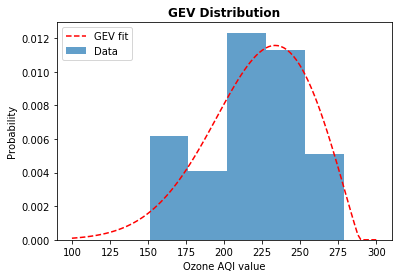

In [9]:
plt.hist(ams.iloc[:,0], bins=5, density=True, alpha=0.7, label='Data')
plt.plot(np.linspace(100, 300, 100),
         ss.genextreme.pdf(np.linspace(100, 300, 100), fit[0], fit[1], fit[2]), 'r--',
         label='GEV fit')
plt.title('GEV Distribution', fontweight='bold')
plt.xlabel('Ozone AQI value')
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.show()

The fit captures the general trend, but it is not great as can be seen by eye. (Further statistical analysis of the quality of the fit is beyond the scope of this lesson.)   

**Question**: What is one reason for the problems with the fit?

**Answer**: One reason is the small dataset (38 points). We also have to be careful how we bin the data for the histogram. Try different values of *bins* and see what happens.

Despite the problems, we can still ask questions that are relevant to human health. For example, what is the probability of exceeding an AQI of 200 in a given year? (Ozone levels above 200 are considered very unhealthy.)

To answer this question, calculate the cumulative distribution function (CDF). 

In [10]:
prob_over_200 = (1.0 - ss.genextreme.cdf(200, fit[0], fit[1], fit[2]))
print('{:.2f}'.format(prob_over_200))

0.75


We might also be concerned about how bad are rare events. For example, what ozone AQI has one percent probability of being exceeded in a given year? This is the same as asking for the AQI at which the CDF is 0.99. We can use the _inverse_ of the CDF, called the _percent point function_ (PPF) to answer this question.

In more detail:
> "Question: What value of X has CDF(X) = 0.99?"
>
> "Answer: PPF(0.99)"

In [11]:
boundary = ss.genextreme.ppf(0.99, fit[0], fit[1], fit[2])
print(f'The one precent threshold ozone AQI level is {boundary:6.4f}')

The one precent threshold ozone AQI level is 280.7103


### Section 1b: Peak Over Threshold

What if you are not interested in the maxima in specific blocks, but want to know about exceeding a threshold more generally? For example, in the ozone case, an exceedance might occur several times a year or not at all in a given year. For such scenarios, the peak of threshold (POT) approach is more appropriate. 

Let us look at all of the ozone data as histogram.

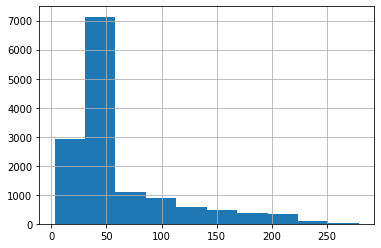

In [12]:
ozone_aqi['Ozone AQI Value'].hist();

We note that most of the data is below an AQI of 100, which is considered moderate to good air quality. (Phew!) We are concerned about the high AQI tail, which can be a health hazard. As we discussed in the lecture, this tail should be well approximated by a universal distribution. 

The task of choosing the threshold for the tail requires some judgement. If it is too low, then the theorems about the universal behavior of the tail do not apply. If it is too high, then there will be few data point in the tail and the resulting estimates for the parameters will be poor. Often, it is a matter of trying different thresholds and looking for a good (enough) fit. 

Here we will use a convenient rule of thumb for where to start the exploration: take the lowest value of the AMS. 

In [13]:
min_max = ams.values.min()
print(f'Lowest maxima value for Ozone AQI in any year: {min_max}')

Lowest maxima value for Ozone AQI in any year: 151


Since we are going to try different values of the threshold, define an appropriate function to create the tail and plot it. 

In [14]:
def plot_tail(threshold):
    ozone_aqi_over_threshold = ozone_aqi[ozone_aqi['Ozone AQI Value'] > threshold]
    ozone_aqi_over_threshold.hist()

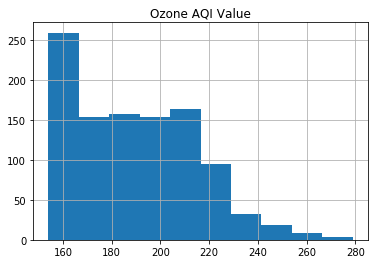

In [15]:
plot_tail(min_max)

We expect the tail to be a decreasing function of the ozone AQI level and here we see a plateau from 170 to 210. Therefore, we will increase the threshold.

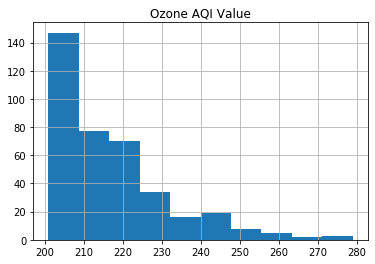

In [16]:
plot_tail(200)

Looks more reasonable. As we discussed in lectures, let us first try to fit an exponential distribution.

In [17]:
threshold = 200
ozone_aqi_threshold = ozone_aqi[ozone_aqi['Ozone AQI Value'] > threshold].iloc[:,0]
fit_expon = ss.expon.fit(ozone_aqi_threshold)
print(fit_expon)

(201.0, 15.779527559055111)


These are the location $\mu$ and scale $\sigma$ parameters, respectively, for an exponential distribution of the form $exp [-(x-\mu)/\sigma]$.

Plot the results together with the exponential fit.

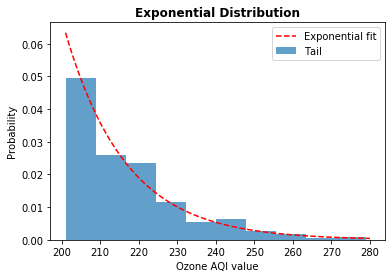

In [18]:
# linspace starts at 201 (one above threshold) to avoid fit going to zero, which looks ugly

plt.hist(ozone_aqi_threshold, bins=10, density=True, alpha=0.7, label='Tail')
plt.plot(np.linspace(201, 280, 100),
         ss.expon.pdf(np.linspace(201, 280, 100), fit_expon[0], fit_expon[1]), 'r--',
         label='Exponential fit')
plt.title('Exponential Distribution', fontweight='bold')
plt.xlabel('Ozone AQI value')
plt.ylabel('Probability')
plt.legend(loc='upper right')
plt.show()



Not bad. You should repeat the analysis above with different thresholds. 

**Question**: How would you decide which threshold to use from all of those you explored?

**Answer:** One way to choose a threshold is the one which gives the smallest mean squared error between the data and the fit. 

As with the block maxima approach, we can now ask questions about different outcomes. Let's revisit the questions we asked before and compare answers.

A. What is the probability of exceeding an AQI of 200 in the time period examined (38 years)? 
Here the answer is 1.00, since we choose our threshold to be 200.

Previously, we found that the probability of exceeding 200 in a given year was 0.75. Therefore, the probability of exceeding 200 at least once in 38 years is $1 - (1 - 0.75)^{38} \approx 1.00$, which is the same as above.

B. Using the block maxima approach, we found that the ozone AQI which has a one percent probability of being exceeded in a given year is 281. Therefore, the probability that this level won't be exceeded over 38 years is $(1 - 0.01)^{38} \approx 0.68$.

From the POT analysis, the probability that the AQI level of 281 won't be exceeded over 38 years is given by



In [19]:
ss.expon.cdf(281, fit_expon[0], fit_expon[1])

0.9937167020146207

which is significantly higher that the block maxima estimate. 

**Question**: Why is there a difference?


**Answer**: One reason has to do with the shape of the GEV vs. that of the POT distribution. The former goes to zero at finite value (289 in our case), while the POT does not. As a result, small changes in the AQI threshold near 289 have a large effect of the GEV probability, but don't have as big an effect on the POT-derived probability.

For example, the 0.1% threshold from GEV is 287. The probability that this level won't be exceeded over 38 years is  $(1-0.001)^{38} \approx 0.96$.

For POT, the same probability is 0.996, which is close to the GEV value.


For completeness, we can fit the data with a generalized Pareto distribution (GPD). As we discussed in lectures, the exponential distribution is a special case of the GPD (shape parameter is zero).

In [20]:
fit2 = ss.genpareto.fit(ozone_aqi_threshold, 20, loc=201, scale=16)
print(fit2)

(-0.06709510873892582, 200.99999967754965, 16.71263276563655)


These are the shape $\xi$, location $\mu$ and scale $\sigma$ parameters, respectively, of the GPD. Note that $\xi$ is very close to zero, which suggests that our initial approach of using an exponential distribution was reasonable. 

Let's look at the fit:

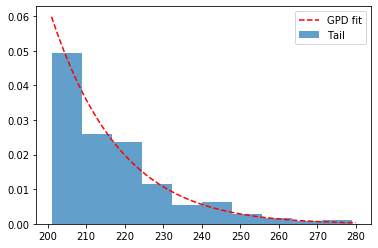

In [21]:
plt.hist(ozone_aqi_threshold, bins=10, density=True, alpha=0.7, label='Tail')
plt.plot(np.linspace(201, 280, 100),
         ss.genpareto.pdf(np.linspace(201, 280, 100), fit2[0], fit2[1], fit2[2]), 'r--',
         label='GPD fit')
plt.legend(loc='upper right')
plt.show()

Very similar to what we found before for the exponential distribution.

**Note**: for a GPD fit to work, we need to specify initial guesses for all of the parameters.  For the location and scale parameters, we chose the values we found for the exponential distribution. Try using different initial guesses and see what you get. Make sure you plot the fit and compare it with the data to check that *genpareto.fit* is producing reasonable output (sometimes it doesn't).

# Section 2: Angle-Based Anomaly Detection

### Introduction

In this section, we use angle-based anomaly detection to detect anomalies in simulated two-dimensional data. A reminder how angle-based anomaly detection works:

1. Choose a point in the data
2. Calculate all angles that this point makes with other pairs of points in the data
3. Calculate the variance of these angles
4. Anomalies have low variance; normal points have high variance 

Typically, you will have training data where you know the anomalies and so can derive a threshold for the variance below which the points will be classified as anomalies. You then apply this threshold to your test data. 

Since here our focus is the algorithm and not the data, we won't carry out a test/train split. Instead, we will use simulated data where we know the anomalies and see how well the algorithm performs.

### Data

We start by creating the data, which will be a combination of normal points and anomalies. Each set of points (normal and anomaly) is generated from a 2D Gaussian distribution where we specify the mean in each dimension as well as the covariance matrix. We choose the normal data to be 100 points tightly clumped together, while the anomalies are 10 points that are further away and spread out more broadly. 

In [22]:
np.random.seed(16) # include a seed for reproducibility

# generate the normal data
normal_mean = np.array([1.0, 2.0]) 
normal_covariance = np.array([[0.2, 0.0], [0.0, 0.1]])
normal_data = np.random.multivariate_normal(normal_mean, normal_covariance, 100)

# generate the anomalous data
anomaly_mean = np.array([6.0, 8.0]) 
anomaly_covariance = np.array([[2.0, 0.0], [0.0, 4.0]])
anomaly_data = np.random.multivariate_normal(anomaly_mean, anomaly_covariance, 10)

# Note:
#
# Do not confuse the two uses of 'normal'
# The 'normal' in np.random.multivariate_normal refers to a Gaussian distribution
# and is not related to normal vs. anomaly
#

# Combine the data into one array for later use
all_data = np.concatenate((normal_data, anomaly_data), axis=0)

Plot the data and color code normal vs. anomaly

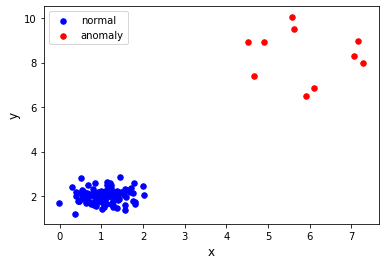

In [23]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.scatter(normal_data[:,0], normal_data[:,1], s=30, c='b', marker="o", label='normal')
ax1.scatter(anomaly_data[:,0], anomaly_data[:,1], s=30, c='r', marker="o", label='anomaly')
plt.legend(loc='upper left');
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

### Algorithm

We will first implement a true angle-based algorithm. That is, we calculate the actual angles for each set of three points in the data. As you will see, this algorithm performs poorly, which leads us to consider an alternative: the distance-weighted angle-based anomaly detection that we discussed in lectures. In Exercise 2, you will be asked implement this distance-weighted algorithm and check how well it identifies anomalies.

We start by constructing the two key functions for the angle-based anomaly detection algorithm. The first function, *angle*, calculates the angle between three points. 


In [24]:
# Given points A, B and C, this function returns the acute angle between vectors AB and AC
# using the dot product between these vectors

def angle(point1, point2, point3): 
    v21 = np.subtract(point2, point1)
    v31 = np.subtract(point3, point1)
    dot_product = (v21*v31).sum()
    normalization = np.linalg.norm(v21)*np.linalg.norm(v31)
    acute_angle = np.arccos(dot_product/normalization)
    return acute_angle

The second function, *eval_angle_point*, takes two inputs: a point and data (a collection of points). This function returns a list of angles that the input point makes with all pairs of points in the input data. It uses *angle* of the angle calculation.

A simple loop through all pairs of points in the data is insufficient because we must make sure the three points lead to well-determined angles without repetition. To be more specific, if we choose point A and then are considering two points in the data B (second point) and C (third point), we want to make sure that the following conditions hold:

1. Point B is different from A
2. Point C is different from A and B
3. We don't calculate the same angle twice. That is, if we calculate the angle between vectors AB and AC (where B is the second point and C is the third point), we don't repeat the calculation with vectors AC and AB (where C is the second point and B is the third point).

The *if* statments in *eval_angle_point* ensure the three conditions hold. 

In [25]:
def eval_angle_point(point, data):
    angles_data = []
    for index_b, b in enumerate(data):
        if (np.array_equal(b, point)):
            continue
        # ensure point c comes later in array that point b
        # so we don't double count points
        for c in data[index_b + 1:]:
            if (np.array_equal(c, point)) or (np.array_equal(c, b)):
                continue
            angles_data.append(angle(point, b, c))
    return angles_data

Now we use *eval_angle_point* with one point from the normal data and another from the anomaly data to illustrate the claim we made above: anomalies have lower angle variance than normal points. 

Choose a normal point and an anomaly at random and plot the angles made for 100 pairs of points in the data.

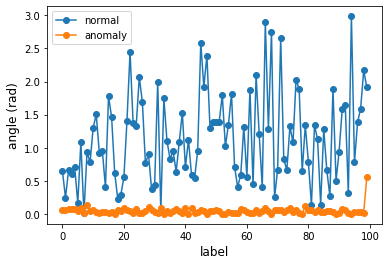

In [26]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot(111)
np.random.seed(17)
normal_point = random.choice(normal_data)
anomaly_point = random.choice(anomaly_data)
normal_angles = eval_angle_point(normal_point, all_data)
anomaly_angles = eval_angle_point(anomaly_point, all_data)
ax2.plot(normal_angles[0:100],  marker="o", label='normal')
ax2.plot(anomaly_angles[0:100], marker="o", label='anomaly')
plt.xlabel('label', fontsize=12)
plt.ylabel('angle (rad)', fontsize=12)
plt.legend(loc='best')
plt.savefig('angle_based.png', dpi=600) # for use in the lecture
plt.show()

In [27]:
print('The normal point is {}'.format(normal_point))
print('The variance in angle for the normal point is {:.5f}'.format(np.var(normal_angles)))
print('The anomaly point is {}'.format(anomaly_point))
print('The variance in angle for the anomaly point is {:.5f}'.format(np.var(anomaly_angles)))

The normal point is [1.29069787 1.49116806]
The variance in angle for the normal point is 0.40047
The anomaly point is [7.16143734 8.98741849]
The variance in angle for the anomaly point is 0.09152


This two point comparison looks promising, but is not statistically meaningful. 

Let's calculate the angle variance for all the anomaly data. We will label the anomalies with type '0' so we can compare them with the normal data (type '1') below.

In [28]:
df_anomaly = pd.DataFrame(columns=['point','angle variance','type'])
for index, item in enumerate(anomaly_data):
    df_anomaly.loc[index] = [item, np.var(eval_angle_point(item, all_data)), 0]

Look at the first ten entries.

In [29]:
df_anomaly.head(10)

,point,angle variance,type
0,"[7.066571495854759, 8.281551528370615]",0.239963,0
1,"[4.912232977610025, 8.944978801062241]",0.447247,0
2,"[5.618891639278701, 9.532065047272486]",0.224829,0
3,"[7.1614373367580715, 8.987418490481454]",0.091516,0
4,"[4.674205174076478, 7.397706178223456]",0.767388,0
5,"[5.586324770476369, 10.062306048806747]",0.092226,0
6,"[7.269879610663201, 7.966183826740902]",0.235928,0
7,"[6.098404325738117, 6.8499254027187835]",0.615849,0
8,"[4.525878242454957, 8.9101902697607]",0.454711,0
9,"[5.91594235166447, 6.4859511951762014]",0.719209,0


This is a little disconcerting. The angle variance for many of the anomalies is quite high--higher even than the variance of the normal point we considered above. To complete our analysis, we also need the variance for the normal data, which we calculate below (labeling normal data as type '1')

In [30]:
df_normal = pd.DataFrame(columns=['point','angle variance','type'])
for index2, item2 in enumerate(normal_data):
    df_normal.loc[index2] = [item2, np.var(eval_angle_point(item2, all_data)), 1]

In [31]:
df_normal.head(10)

,point,angle variance,type
0,"[1.057220407617929, 1.5166542526994613]",0.442425,1
1,"[0.7341458372525282, 2.020975505908734]",0.810849,1
2,"[0.44746989551628713, 1.8035059930728545]",0.326829,1
3,"[0.6024504585701147, 2.157769149062043]",0.629593,1
4,"[0.648088917734629, 2.0375500118982566]",0.701444,1
5,"[0.6615205158568662, 2.1560163153875744]",0.706020,1
6,"[0.6246069790039117, 1.6790219066107057]",0.432611,1
7,"[0.8468205401506654, 2.5959198435039514]",0.580395,1
8,"[0.8788440637281327, 1.5409260367027504]",0.419533,1
9,"[0.5169382272892247, 2.811148431089265]",0.377435,1


***Question:*** Why is the calculation for *normal_data* relatively slow? (Hint: What is the complexity of the algorithm?)

***Answer:*** The complexity of the algorithm is $O(N^{3})$ where $N$ is the number of points.

To see this, think about how an angle is calculated. You need three points, and they should all be different. There are $N$ ways to choose the first point, $N-1$ ways to choose the second one and $N-2$ to choose the third. Swapping the second and third points gives the same angle, so the overall complexity is $N*(N-1)*(N-2)/2 = O(N^{3})$.

Note that here we've split the algorithm into two parts: *eval_angle_point* calculates all angles for a given point [complexity $O(N^{2})$] and then the final loops above (for *df_anomaly* and *df_normal*) go through all points  [complexity $O(N)$]

Going from 10 points for the anomalies to 100 points of normal data, increases the runtime by about a factor of $10^3=1000$, which leads to a noticeable slowdown. As we discussed, in the lectures, there are ways to speed up the algorithm, but even in the fancier versions, angle-based anomaly detection is slow.

Combine the two dataframes for the anomalies and the normal points and sort them in ascending order by angle variance. If our anomaly detection algorithm is perfect, then the first ten entries should all be anomalies (type 0).

In [32]:
df_all = df_anomaly.append(df_normal, ignore_index=True)
df_all.sort_values(by=['angle variance']).head(10)

,point,angle variance,type
43,"[-0.007963240085042012, 1.6819486434208086]",0.085313,1
25,"[0.3717420163194104, 1.213654699499786]",0.091273,1
3,"[7.1614373367580715, 8.987418490481454]",0.091516,0
5,"[5.586324770476369, 10.062306048806747]",0.092226,0
2,"[5.618891639278701, 9.532065047272486]",0.224829,0
6,"[7.269879610663201, 7.966183826740902]",0.235928,0
0,"[7.066571495854759, 8.281551528370615]",0.239963,0
78,"[1.5633761101073278, 1.3905898245810073]",0.258711,1
90,"[0.29736034146994617, 2.4299459590107038]",0.268153,1
105,"[1.004238386524476, 1.4325277933330982]",0.310493,1


Oops! We find only five of the ten anomalies and the two points with the lowest variance belong to the normal data. Clearly our algorithm needs some work. You will improve it in Exercise 2.

# Section 3: Depth-Based Anomaly Detection

### Introduction

In this section, we use depth-based anomaly detection to detect anomalies in simulated two-dimensional data. Just like angle-based anomaly detection, depth-based anomaly detection uses the geometric structure of the data, rather than an underlying probability distribution, to find anomalies. 

While it is clear what we mean by angle, the concept of depth must be defined. The general idea of depth is to assign a numerical value to each point. As with angle variance, points below a certain value of depth are considered anomalies.

Here we will take the depth to be the convex-hull peeling depth as defined below.
(see also *Lesson 2* lecture and http://www.cs.tufts.edu/r/geometry/pdf/alenex06-deptheexplorer.pdf)

The depth of a point X with respect to a dataset S (made of many points including X)
is the level of the convex layer to which X belongs. The level of the convex layer is defined
as follows: the points on the outer convex hull of S are designated level one and the points on the jth level (with j a positive integer) are the points on the convex hull of S after the points on all previous levels have been removed.

Using this definition, we carry out the depth-based anomaly detection as follows:

1. Construct the convex hull for the data
2. Label the points on the hull as depth 1
3. Remove the depth 1 points
4. Construct the the convex hull for the remaining data
5. Label the points on the hall as depth 2
6. Remove the depth 2 points
7. Continue steps (4-6) incrementing the depth level by one each time
8. Once there aren't enough points left to construct a convex hull, increment the depth and label the remaining points (if any) with the final depth value and end the convex hull construction
9. The anomalies are those points whose depth values are below a pre-selected threshold 

Given the structure of the algorithm, we expect to implement it recursively.

### Data

We will illustrate the algorith with a 2D dataset. As we mentioned in the lecture, the depth-based slows down significantly as the dimensionality increases. We will work with a small dataset for visual clarity.

In [33]:
# Select 30 random points from a 2D uniform distribution between zero and one
np.random.seed(20)
points = np.random.rand(30, 2)   

Plot the data

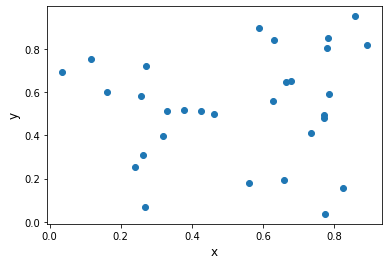

In [34]:
plt.plot(points[:, 0], points[:, 1], 'o')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

### Algorithm

We will construct a series of convex hulls. Let's look at the one for all the data, which produces the points of depth 1.

There is a ready-made Python function to construct the convex hull.

In [35]:
from scipy.spatial import ConvexHull
hull = ConvexHull(points)

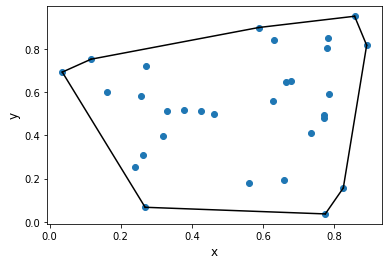

In [36]:
plt.plot(points[:, 0], points[:, 1], 'o')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
for simplex in hull.simplices:
    # In 2D, the simplicies are the lines connecting the points on the hull
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.show()

Now to implement the recursive convex hull construction.

In [37]:
# The function *depth_calculator* takes three inputs: 
# the data; 
# a dictionary, which *depth_calculator* fills 
# with the coordinates of each point (key) and its corresponding depth (value);
# a counter to keep track of the depth. Its initial value is the depth of the outermost hull

def depth_calculator(data, dict, count):
    next_data = []
    if len(data) < 3: # in 2D, at least three points are needed to make a convex hull 
        for index, item in enumerate(data):
            dict[tuple(item)] = count # assign depth to remaining points
        print('All done! Need at least 3 points to construct a convex hull. ')  # End
    else:
        hull = ConvexHull(data) # Construct convex hull
        for index, item in enumerate(data):
            if item in data[hull.vertices]:
                dict[tuple(item)] = count # assign depth to points on hull
            else:
                dict[tuple(item)] = count + 1.0 # assign depth+1 to points not on hull
                next_data.append(item)
        new_data =np.asarray(next_data) # create new data file of points not on hull 
        depth_calculator(new_data, dict, count + 1.0) # repeat on new data file



In [38]:
depth_dict = {} # empty dictionary for depth_calculator
depth_calculator(points, depth_dict, 1.0) # initial hull has depth 1.0

All done! Need at least 3 points to construct a convex hull. 


Plot the points with their depth as an annotation

In [39]:
def depth_plot (dict):
    xs,ys = zip(*dict.keys())
    depth_label = list(dict.values())   
    plt.figure(figsize=(8,6))
    plt.title('Depth Labels', fontsize=20)
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.scatter(xs, ys, marker = 'o',)
    for label, x, y in zip(depth_label, xs, ys):
        plt.annotate(label, xy = (x, y), xytext=(3,3), textcoords='offset points')

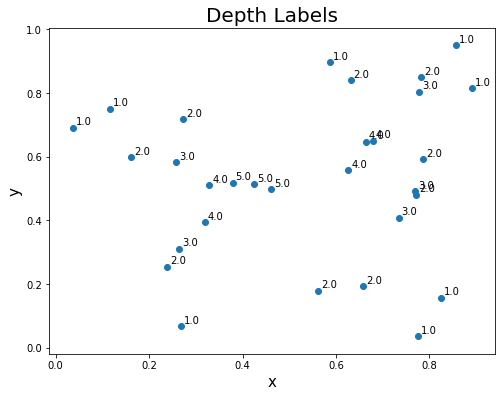

In [40]:
depth_plot(depth_dict)

You can see in this plot that points labeled '1.0' are those on the initial convex hull. Also, the final three points (depth 5.0) formed a triangle after which no points were left and the algorithm ended.

Assuming we had set initially our anomaly threshold to be 1.0, we would have eight anomalies. Of course, in this case, there would be no need for a recursive approach--just take the points on the outermost convex hull. However, sometimes the depth is used as a score (a measure of how anomalous a point is). In such cases, it is useful to label all points.

### Exercise #1

This exercise refers to Section 1a, the analysis of the ozone data using the block maxima approach.

A. Repeat the analysis above using a monthly maximum series (MMS) instead of an annual one.

B. How do your results differ from the AMS case?

C. What are the pros and cons of using MMS vs. AMS?


### Solution #1

In [41]:
# YOUR CODE HERE

### Exercise #2

This exercise refers to Section 2 (angle-based anomaly detection).

A. Change the angle calculation so that it computed a modified angle between two vectors $\bf{a}$ and $\bf{b}$ as discussed in lectures:

\begin{equation}
\theta_{\rm mod} = \frac{\bf{a} \dot \bf{b}}{a^{2}b^{2}}
\end{equation}

where $a$ and $b$ are the absolute values of $\bf{a}$ and $\bf{b}$, respectively.

B. Repeat the anomaly detection using the modified angle. Does this algorithm perform better?

C. Has the complexity of the algorithm changed? If so, what is the new complexity?

### Solution #2

In [42]:
# YOUR CODE HERE

### Exercise #3

This exercise refers to Section 3 (depth-based anomaly detection). 

A. Apply the depth-based anomaly detection algorithm to the data in section 2. 

B. How successful is the algorithm at finding the anomalies?

C. How do your results compare with the angle-based anomaly detection algorithms (both versions)?



### Solution #3

In [43]:
# YOUR CODE HERE

# Summary

In this assignment you should have learned: 

1. Two approaches to extreme value analysis: block maxima and peak over threshold
2. How to apply angle-based anomaly detection 
3. How to apply depth-based anomaly detection 

Congratulations! This concludes the lesson.

In [44]:
print('end')

end
